In [1]:
!python --version

Python 3.10.12


In [2]:
!wget -qq https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf -O arial.ttf
!wget -qq https://github.com/foursquare/foursquair/raw/master/src/assets/fonts/Arial%20Bold.ttf -O arial_bold.ttf

In [3]:
import cv2
import yaml
import math
import random
import pickle
import numpy as np
import pandas as pd
from enum import Enum
from tqdm import tqdm
from random import seed
from collections import Counter
seed(10)

import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image, ImageDraw, ImageFont

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from typing import List
from dataclasses import dataclass
from abc import ABC, abstractmethod
from IPython.display import display

pd.set_option('display.max_columns', None)

# Force-directed Layout for PAGs

Position nodes using Fruchterman-Reingold force-directed algorithm.

The algorithm simulates a force-directed representation of the network treating edges as springs holding nodes close, while treating nodes as repelling objects, sometimes called an anti-gravity force. Simulation continues until the positions are close to an equilibrium.


In [4]:
LINE_WIDTH = 5
THIN_LINE_WIDTH = 1
adjust = LINE_WIDTH // 2
adjust_e = adjust + 1
adjust_d = adjust_e - adjust

def approximate_grid_layout(nob):
    """Approximates the number of rows and columns to arrange a given number of objects."""

    if nob <= 0:
        return 0, 0  # Handle invalid input

    # Find the closest perfect square less than or equal to nob
    approx_side = math.floor(math.sqrt(nob))

    # Calculate ideal rows and columns based on a square arrangement
    ideal_rows = approx_side
    ideal_columns = approx_side

    # Adjust if needed to distribute objects more evenly
    remainder = nob - (ideal_rows * ideal_columns)
    if remainder > 0:
        if remainder <= ideal_columns:
            ideal_rows += 1  # Add a row
        else:
            ideal_columns += 1  # Add a column

    return ideal_rows, ideal_columns

class GridSystem:
    def __init__(self, canvas_width, canvas_height, block_width, block_height):
        self.canvas_width = canvas_width
        self.canvas_height = canvas_height
        self.block_width = block_width          # h
        self.block_height = block_height        # v
        self.grid_lines_h = {f'h{i}': i * self.block_width for i in range(self.canvas_height // self.block_width + 1)}
        self.grid_lines_v = {f'v{i}': i * self.block_height for i in range(self.canvas_width // self.block_height + 1)}

    def calculate_block_sizes(self):
        horizontal_sizes = [y - prev_y for prev_y, y in zip([0] + list(self.grid_lines_h.values()), list(self.grid_lines_h.values()) + [self.canvas_height])]
        vertical_sizes = [x - prev_x for prev_x, x in zip([0] + list(self.grid_lines_v.values()), list(self.grid_lines_v.values()) + [self.canvas_width])]
        return horizontal_sizes, vertical_sizes


    def draw_grid(self):
        image = Image.new('RGB', (self.canvas_width, self.canvas_height), color='white')
        draw = ImageDraw.Draw(image)

        # Calculate block sizes dynamically
        horizontal_sizes, vertical_sizes = self.calculate_block_sizes()

        # Draw horizontal lines
        for i, size in self.grid_lines_h.items():
            draw.line([(0, size), (self.canvas_width, size)], fill='#999999', width=THIN_LINE_WIDTH)

        # Draw vertical lines
        for i, size in self.grid_lines_v.items():
            draw.line([(size, 0), (size, self.canvas_height)], fill='#999999', width=THIN_LINE_WIDTH)

        return image, draw

    def remove_grid_line(self, grid_id):
        orientation, line_id = grid_id[0], int(grid_id[1:])
        if orientation == 'h' and grid_id in self.grid_lines_h:
            del self.grid_lines_h[grid_id]
        elif orientation == 'v' and grid_id in self.grid_lines_v:
            del self.grid_lines_v[grid_id]

    def fill_blocks_around_point(self, point, target_area):
        x, y = point

        # Find the block IDs for the given point
        block_id_h = f'h{y // self.block_height}'
        block_id_v = f'v{x // self.block_width}'

        # Calculate the number of blocks to be filled based on the target area
        nob = max(1, round(target_area / (self.block_width * self.block_height)))
        num_rows, num_columns = approximate_grid_layout(nob)

        area_diff = abs(target_area - nob * self.block_width * self.block_height)
        # print(f"Rectangle: true area: {target_area} | block_area: {nob * self.block_width * self.block_height} | {target_area / (self.block_width * self.block_height)} -> {round(target_area / (self.block_width * self.block_height))} | {num_rows}x{num_columns}")

        # Adjust the starting block to ensure the point is in the center
        start_block_h = max(int(y // self.block_height - num_rows // 2), 1)
        start_block_v = max(int(x // self.block_width - num_columns // 2), 1)

        start_block_h = min(start_block_h, len(self.grid_lines_h.keys()) - num_rows)
        start_block_v = min(start_block_v, len(self.grid_lines_v.keys()) - num_columns)

        # Calculate the coordinates for the single rectangle around the point
        top_left_x = self.grid_lines_v[f'v{start_block_v}']
        top_left_y = self.grid_lines_h[f'h{start_block_h}']
        bottom_right_x = self.grid_lines_v[f'v{start_block_v + num_columns - 1}'] + self.block_width
        bottom_right_y = self.grid_lines_h[f'h{start_block_h + num_rows - 1}'] + self.block_height

        # # Remove intersecting horizontal lines
        # for i in range(start_block_h + 1, start_block_h + num_rows):
        #     line_id = f'h{i}'
        #     self.remove_grid_line(line_id)

        # # Remove intersecting vertical lines
        # for j in range(start_block_v + 1, start_block_v + num_columns):
        #     line_id = f'v{j}'
        #     self.remove_grid_line(line_id)

        return [(top_left_x, top_left_y), (bottom_right_x, bottom_right_y)], area_diff

    def plot_points_fill_blocks(self, points, target_areas, visualize=True):
        if visualize:
            image, draw = self.draw_grid()
        rectangles = []

        # Increase the size of the plotted points for better visibility
        point_size = 3
        area_diff = 0

        for point, target_area in zip(points, target_areas):
            x, y = point

            # Find the block IDs for the given point
            # block_id_h = f'h{y // self.block_height}'
            # block_id_v = f'v{x // self.block_width}'
            # print(f'Point ({x}, {y}) is in block {block_id_h}, {block_id_v}')

            # Fill blocks around the point based on the target area
            rect, diff = self.fill_blocks_around_point(point, target_area)
            rectangles.append(rect)
            area_diff += diff


        # adjustment
        if visualize:
            # for (top_left_x, top_left_y), (bottom_right_x, bottom_right_y) in rectangles:
            #     draw.rectangle([(top_left_x - adjust, top_left_y - adjust), (bottom_right_x + adjust, bottom_right_y + adjust)], fill=None, outline="black", width=LINE_WIDTH)

            for x, y in points:
                draw.ellipse((x - point_size, y - point_size, x + point_size, y + point_size), fill='blue')


        def calculate_overlapped_area(rectangles):
            total_area = 0
            n = len(rectangles)

            for i in range(n - 1):
                for j in range(i + 1, n):
                    rect1 = rectangles[i]
                    rect2 = rectangles[j]

                    x_overlap = max(0, min(rect1[1][0], rect2[1][0]) - max(rect1[0][0], rect2[0][0]))
                    y_overlap = max(0, min(rect1[1][1], rect2[1][1]) - max(rect1[0][1], rect2[0][1]))

                    overlap_area = x_overlap * y_overlap
                    total_area += overlap_area

            return total_area
        overlap = calculate_overlapped_area(rectangles)
        # print(f"OVERLAPPED AREA: {overlap}")
        # print(f"AREA DIFF: {area_diff}")
        score = overlap + area_diff
        if visualize:
            return rectangles, image, overlap
        else:
            return rectangles, overlap


# for data preparation
def get_points(pag_df, scale = 1):
    return [(pag_df['x'].iloc[i] * scale, pag_df['y'].iloc[i] * scale) for i in range(len(pag_df))]

def get_relations(mem_df, th=2):
    relations = []
    rel_count = {}
    for key in set(mem_df["GS_A_ID"]):
        rel_count[key[-4:]] = 0
    for index, row in mem_df.iterrows():
        if (row["GS_B_ID"][-4:], row["GS_A_ID"][-4:]) not in relations and \
        rel_count[row["GS_A_ID"][-4:]] < th and rel_count[row["GS_B_ID"][-4:]] < th:
            relations.append((row["GS_A_ID"][-4:], row["GS_B_ID"][-4:]))
            rel_count[row["GS_A_ID"][-4:]] += 1
            rel_count[row["GS_B_ID"][-4:]] += 1
    return relations

def get_area(pag_df, scale):
    return list(pag_df['abs_log_wfc'] * scale)

def get_color(pag_df):
    return list(pag_df['color'])

def get_pagIDs(pag_df):
    return [id[-4:] for id in pag_df["GS_ID"]]




# PMAP CORE

def blank_canvas():
    Corner.instances = []
    Block.instances = {}
    Line.instances = []

class Colors(str, Enum):
    WHITE = "#FFFFFF"
    # RED = "#dd271c"   # mine
    # BLUE = "#015da1"
    # YELLOW = "#f2dd74"

    GRAY = "#3e3f39"    # https://color.adobe.com/De-Stijl---Piet-Mondrian-color-theme-6225068/
    BLACK = "#050103"
    BLACK_A = "#05010333"

    RED = "#E70503"
    BLUE = "#0300AD"
    YELLOW = "#FDDE06"

    RED_A = "#E7050345"
    BLUE_A = "#0300AD45"
    YELLOW_A = "#FDDE0645"

    SOLID = [RED, BLUE, YELLOW, GRAY, BLACK]
    TRANS = [RED_A, BLUE_A, YELLOW_A, BLACK_A]

def get_color_map(color):
    if color == "red": return Colors.RED
    if color == "blue": return Colors.BLUE
    if color == "yellow": return Colors.YELLOW
    if color == "black": return Colors.BLACK
    if color == "gray": return Colors.GRAY

    if color == "red_a": return Colors.RED_A
    if color == "blue_a": return Colors.BLUE_A
    if color == "yellow_a": return Colors.YELLOW_A
    if color == "black_a": return Colors.BLACK_A

class Ratio(float, Enum):
    SQUARE = 1
    GOLDEN_H = 1/1.6
    GOLDEN_W = 1.6/1
    LONG_H = 1/2
    LONG_W = 2/1

class CornerPos(int, Enum):
    TOP_LEFT = 0
    TOP_RIGHT = 1
    BOTTOM_LEFT = 2
    BOTTOM_RIGHT = 3

class LineDir(str, Enum):
    RIGHT = "left_to_right"
    LEFT = "right_to_left"
    DOWN = "up_to_down"
    UP = "down_to_up"


class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return f"({round(self.x, 2)}, {round(self.y, 2)})"

class Line:
    instances = []
    def __init__(self, point_a: Point, point_b: Point, direction: LineDir, color: Colors = Colors.BLACK, strength: int = LINE_WIDTH):
        self.point_a = point_a
        self.point_b = point_b
        self.direction = direction
        self.color = color
        self.strength = strength
        self.instances.append(self)

    def __str__(self):
        return f"({self.point_a.x}, {self.point_a.y}) to ({self.point_b.x}, {self.point_b.y})"

    def draw(self, image: Image.Image):
        draw = ImageDraw.Draw(image)
        draw.line((self.point_a.x, self.point_a.y, self.point_b.x, self.point_b.y), fill=self.color, width=self.strength)

class Corner:
    instances = []

    def __init__(self, point: Point, position: CornerPos, line: Line = None):
        self.point = point
        self.position = position
        self.line = line
        self.instances.append(self)

    def __str__(self):
        return f"{self.position}: ({round(self.point.x, 2)}, {round(self.point.y, 2)})"

    def draw(self, image: Image.Image):
        draw = ImageDraw.Draw(image)
        draw.ellipse((self.point.x, self.point.y, self.point.x, self.point.y), fill=Colors.BLUE)


class Block:
    instances = {}
    def __init__(self, top_left, bottom_right, area: float, color: Colors, id: str):
        self.top_left_p = top_left
        self.bottom_right_p = bottom_right

        self.top_left = Corner(Point(self.top_left_p[0] - adjust, self.top_left_p[1] - adjust), CornerPos.TOP_LEFT)
        self.top_right = Corner(Point(self.bottom_right_p[0] + adjust, self.top_left_p[1] - adjust), CornerPos.TOP_RIGHT)
        self.bottom_left = Corner(Point(self.top_left_p[0] - adjust, self.bottom_right_p[1] + adjust), CornerPos.BOTTOM_LEFT)
        self.bottom_right = Corner(Point(self.bottom_right_p[0] + adjust, self.bottom_right_p[1] + adjust), CornerPos.BOTTOM_RIGHT)

        self.center = Point((self.top_left.point.x + self.bottom_right.point.x) / 2, (self.top_left.point.y + self.bottom_right.point.y) / 2)
        self.area = area
        self.color = get_color_map(color)
        self.id = id
        self.instances[id] = self

        Line(Point(self.top_left.point.x, self.top_left.point.y + adjust), Point(self.top_right.point.x, self.top_right.point.y + adjust), LineDir.RIGHT)
        Line(Point(self.top_right.point.x - adjust, self.top_right.point.y), Point(self.bottom_right.point.x - adjust, self.bottom_right.point.y), LineDir.DOWN)
        Line(Point(self.bottom_right.point.x, self.bottom_right.point.y - adjust), Point(self.bottom_left.point.x, self.bottom_left.point.y - adjust), LineDir.LEFT)
        Line(Point(self.bottom_left.point.x + adjust, self.bottom_left.point.y), Point(self.top_left.point.x + adjust, self.top_left.point.y), LineDir.UP)

    def __str__(self):
        return f"Block ID: {self.id}"

    @property
    def height(self):
        return self.bottom_left.point.x - self.top_left.point.x

    @property
    def width(self):
        return self.top_right.point.x - self.top_left.point.x

    def draw(self, image: Image.Image):
        draw = ImageDraw.Draw(image)

        left_upper = (self.top_left.point.x, self.top_left.point.y)
        right_lower = (self.bottom_right.point.x, self.bottom_right.point.y)
        if self.color in Colors.SOLID:
            border_color = Colors.BLACK
        else:
            border_color = Colors.BLACK_A
        draw.rectangle([left_upper, right_lower], outline=Colors.BLACK, fill=self.color, width=LINE_WIDTH)

        if self.color == Colors.YELLOW:
            annot_color = Colors.GRAY
        else:
            annot_color = Colors.WHITE
        if self.width < self.height:
            direction = "ttb"
        else:
            direction = 'ltr'
        draw.text((self.top_left.point.x+5, self.top_left.point.y+3.5), str(self.id)[-4:],
                    fill=annot_color, font=ImageFont.truetype("arial_bold.ttf", round(np.log2(self.area)*1.2)),
                    direction=direction)


def get_closest_corner(block_a: Block, block_b: Block) -> Corner:
    min_distance = float('inf')
    closest_corner = None

    for corner in [block_a.top_left, block_a.top_right, block_a.bottom_right, block_a.bottom_left]:
        distance = abs(corner.point.x - block_b.center.x) + abs(corner.point.y - block_b.center.y)
        if distance < min_distance:
            min_distance = distance
            closest_corner = corner

    return closest_corner

def get_line_direction(point_a: Point, point_b: Point):
    # if point_a.x == point_b.x and point_a.y == point_b.y:
    #     return LineDir.NONE
    if abs(point_a.x - point_b.x) <= adjust:     # due to adjustment error
        if point_a.y < point_b.y:
            return LineDir.DOWN
        else:
            return LineDir.UP
    elif abs(point_a.y - point_b.y) <= adjust:
        if point_a.x < point_b.x:
            return LineDir.RIGHT
        else:
            return LineDir.LEFT
    else:
        print(point_a, point_b)
        print("WARNING: line.direction is None")
        return None

def filtered_blocks(relation):
    return [Block.instances[bid] for bid in Block.instances.keys() if bid not in relation]

def check_manhattan_line_intersection(manhattan_lines, rel):
    """RETURNS TRUE IF INTERSECTION HAPPENS"""
    for line in manhattan_lines:
        for blk in filtered_blocks(rel):
            if is_line_intersecting_rectangle((line.point_a, line.point_b), (blk.top_left.point, blk.bottom_right.point)):
                return True
    return False

def get_manhattan_lines(corner_a: Corner, corner_b: Corner) -> List[Line]:
    if corner_a.point.x == corner_b.point.x and corner_a.point.y != corner_b.point.y:
        print("VERTICAL MANHATTAN LINE")
        if corner_a.position in [CornerPos.TOP_LEFT, CornerPos.BOTTOM_LEFT]:
            line_v = Line(Point(corner_a.point.x + adjust, corner_a.point.y), Point(corner_b.point.x + adjsut, corner_b.point.y), get_line_direction(corner_a.point, corner_b.point))
        if corner_a.position in [CornerPos.TOP_RIGHT, CornerPos.BOTTOM_RIGHT]:
            line_v = Line(Point(corner_a.point.x - adjust, corner_a.point.y), Point(corner_b.point.x - adjsut, corner_b.point.y), get_line_direction(corner_a.point, corner_b.point))
        corner_a.line = line_v
        corner_b.line = line_v
        return [line_v]

    elif (corner_a.point.x != corner_b.point.x and corner_a.point.y == corner_b.point.y):
        print("HORIZONTAL MANHATTAN LINE")
        if corner_a.position in [CornerPos.TOP_LEFT, CornerPos.TOP_RIGHT]:
            line_h = Line(Point(corner_a.point.x, corner_a.point.y + adjust), Point(corner_b.point.x, corner_b.point.y + adjust), get_line_direction(corner_a.point, corner_b.point))
        elif corner_a.position in [CornerPos.BOTTOM_LEFT, CornerPos.BOTTOM_RIGHT]:
            line_h = Line(Point(corner_a.point.x, corner_a.point.y - adjust), Point(corner_b.point.x, corner_b.point.y - adjust), get_line_direction(corner_a.point, corner_b.point))
        corner_a.line = line_h
        corner_b.line = line_h
        return [line_h]

    elif corner_a.point.x != corner_b.point.x and corner_a.point.y != corner_b.point.y:
        # DECISION POINT: large > small or small > large
        if (corner_a.point.x - corner_b.point.x) > abs(corner_a.point.y - corner_b.point.y):
            connector = Point(corner_a.point.x, corner_b.point.y)
        else:
            connector = Point(corner_b.point.x, corner_a.point.y)

        if corner_a.position in [CornerPos.TOP_LEFT] and get_line_direction(corner_a.point, connector) in [LineDir.RIGHT, LineDir.LEFT]:
            corner_a_point = Point(corner_a.point.x - adjust_d, corner_a.point.y + adjust)
            connector = Point(connector.x, connector.y + adjust)

        elif corner_a.position in [CornerPos.TOP_RIGHT] and get_line_direction(corner_a.point, connector) in [LineDir.RIGHT, LineDir.LEFT]:
            corner_a_point = Point(corner_a.point.x + adjust_d, corner_a.point.y + adjust)
            connector = Point(connector.x, connector.y + adjust)       # DEBUG

        elif corner_a.position in [CornerPos.TOP_RIGHT] and get_line_direction(corner_a.point, connector) in [LineDir.UP, LineDir.DOWN]:
            corner_a_point = Point(corner_a.point.x - adjust, corner_a.point.y - adjust_d)
            connector = Point(connector.x - adjust, connector.y)

        elif corner_a.position in [CornerPos.BOTTOM_RIGHT] and get_line_direction(corner_a.point, connector) in [LineDir.UP, LineDir.DOWN]:
            corner_a_point = Point(corner_a.point.x - adjust, corner_a.point.y + adjust_d)
            connector = Point(connector.x - adjust, connector.y)

        elif corner_a.position in [CornerPos.BOTTOM_RIGHT] and get_line_direction(corner_a.point, connector) in [LineDir.RIGHT, LineDir.LEFT]:
            corner_a_point = Point(corner_a.point.x + adjust_d, corner_a.point.y - adjust)
            connector = Point(connector.x, connector.y - adjust)

        elif corner_a.position in [CornerPos.BOTTOM_LEFT] and get_line_direction(corner_a.point, connector) in [LineDir.RIGHT, LineDir.LEFT]:
            corner_a_point = Point(corner_a.point.x - adjust_d, corner_a.point.y - adjust)
            connector = Point(connector.x, connector.y - adjust)

        elif corner_a.position in [CornerPos.BOTTOM_LEFT] and get_line_direction(corner_a.point, connector) in [LineDir.UP, LineDir.DOWN]:
            corner_a_point = Point(corner_a.point.x + adjust, corner_a.point.y + adjust_d)    # DEBUG
            connector = Point(connector.x + adjust, connector.y)

        elif corner_a.position in [CornerPos.TOP_LEFT] and get_line_direction(corner_a.point, connector) in [LineDir.UP, LineDir.DOWN]:
            corner_a_point = Point(corner_a.point.x + adjust, corner_a.point.y - adjust_d)    # DEBUG
            connector = Point(connector.x + adjust, connector.y)

        line_a = Line(corner_a_point, connector, get_line_direction(corner_a_point, connector), color=Colors.RED, strength=LINE_WIDTH)

        if corner_b.position in [CornerPos.TOP_LEFT, CornerPos.TOP_RIGHT] and get_line_direction(connector, corner_b.point) in [LineDir.RIGHT, LineDir.LEFT]:
            if get_line_direction(connector, corner_b.point) == LineDir.RIGHT:
                connector = Point(connector.x - adjust, connector.y + adjust)
            elif get_line_direction(connector, corner_b.point) == LineDir.LEFT:
                connector = Point(connector.x + adjust, connector.y + adjust)

            if corner_b.position == CornerPos.TOP_RIGHT:            # and get_line_direction(connector, corner_b.point) == LineDir.LEFT
                corner_b_point = Point(corner_b.point.x + adjust_d, corner_b.point.y + adjust)

            elif corner_b.position == CornerPos.TOP_LEFT:           #  and get_line_direction(connector, corner_b.point) == LineDir.RIGHT
                corner_b_point = Point(corner_b.point.x - adjust_d, corner_b.point.y + adjust)

        elif corner_b.position in [CornerPos.TOP_RIGHT, CornerPos.BOTTOM_RIGHT] and get_line_direction(connector, corner_b.point) in [LineDir.DOWN, LineDir.UP]:
            if get_line_direction(connector, corner_b.point) == LineDir.DOWN:
                connector = Point(connector.x - adjust, connector.y - adjust)
            elif get_line_direction(connector, corner_b.point) == LineDir.UP:
                connector = Point(connector.x - adjust, connector.y + adjust)

            if corner_b.position == CornerPos.TOP_RIGHT:                # and get_line_direction(connector, corner_b.point) == LineDir.DOWN
                corner_b_point = Point(corner_b.point.x - adjust, corner_b.point.y - adjust_d)
            elif corner_b.position == CornerPos.BOTTOM_RIGHT:           #  and get_line_direction(connector, corner_b.point) == LineDir.UP
                corner_b_point = Point(corner_b.point.x - adjust, corner_b.point.y + adjust_d)

        elif corner_b.position in [CornerPos.BOTTOM_RIGHT, CornerPos.BOTTOM_LEFT] and get_line_direction(connector, corner_b.point) in [LineDir.RIGHT, LineDir.LEFT]:
            if get_line_direction(connector, corner_b.point) == LineDir.RIGHT:
                connector = Point(connector.x - adjust, connector.y - adjust)
            elif get_line_direction(connector, corner_b.point) == LineDir.LEFT:
                connector = Point(connector.x + adjust, connector.y - adjust)

            if corner_b.position == CornerPos.BOTTOM_RIGHT:         # and get_line_direction(connector, corner_b.point) == LineDir.LEFT
                corner_b_point = Point(corner_b.point.x + adjust_d, corner_b.point.y - adjust)
            elif corner_b.position == CornerPos.BOTTOM_LEFT:        #  and get_line_direction(connector, corner_b.point) == LineDir.RIGHT
                corner_b_point = Point(corner_b.point.x - adjust_d, corner_b.point.y - adjust)

        elif corner_b.position in [CornerPos.BOTTOM_LEFT, CornerPos.TOP_LEFT] and get_line_direction(connector, corner_b.point) in [LineDir.DOWN, LineDir.UP]:
            if get_line_direction(connector, corner_b.point) == LineDir.DOWN:
                connector = Point(connector.x + adjust, connector.y - adjust)
            elif get_line_direction(connector, corner_b.point) == LineDir.UP:
                connector = Point(connector.x + adjust, connector.y + adjust)

            if corner_b.position == CornerPos.TOP_LEFT:             #  and get_line_direction(connector, corner_b.point) == LineDir.DOWN
                corner_b_point = Point(corner_b.point.x + adjust, corner_b.point.y - adjust_d)
            elif corner_b.position == CornerPos.BOTTOM_LEFT:        #  and get_line_direction(connector, corner_b.point) == LineDir.UP      # DEBUG
                corner_b_point = Point(corner_b.point.x + adjust, corner_b.point.y + adjust_d)

        line_b = Line(connector, corner_b_point, get_line_direction(connector, corner_b_point), color=Colors.RED, strength=LINE_WIDTH)

        # if line_a is overlapping, return only line_b
        if line_a.direction in [LineDir.LEFT, LineDir.RIGHT]:
            horizontal_lines = [line for line in Line.instances if line.direction in [LineDir.LEFT, LineDir.RIGHT] and line_a != line]
            overlapping = is_overlapping_h(line_a, horizontal_lines)
            if overlapping:
                corner_b.line = line_b
                return [line_b]
        elif line_a.direction in [LineDir.UP, LineDir.DOWN]:
            vertical_lines = [line for line in Line.instances if line.direction in [LineDir.UP, LineDir.DOWN] and line_a != line]
            overlapping = is_overlapping_v(line_a, vertical_lines)
            if overlapping:
                corner_b.line = line_b
                return [line_b]

        # if line_b is overlapping, return only line_a
        if line_b.direction in [LineDir.LEFT, LineDir.RIGHT]:
            horizontal_lines = [line for line in Line.instances if line.direction in [LineDir.LEFT, LineDir.RIGHT] and line_b != line]
            overlapping =  is_overlapping_h(line_b, horizontal_lines)
            if overlapping:
                corner_a.line = line_a
                return [line_a]
        elif line_b.direction in [LineDir.UP, LineDir.DOWN]:
            vertical_lines = [line for line in Line.instances if line.direction in [LineDir.UP, LineDir.DOWN] and line_b != line]
            overlapping = is_overlapping_v(line_b, vertical_lines)
            if overlapping:
                corner_a.line = line_a
                return [line_a]

        corner_a.line = line_a
        corner_b.line = line_b
        # print(f'corner_a_line {corner_a.line}')
        # print(f'corner_b_line {corner_b.line}')
        return [line_a, line_b]

def is_overlapping_h(line1, horizontal_lines):
    assert line1.point_a.y == line1.point_b.y
    y1 = line1.point_a.y  # Y-coordinate of the given line

    for line2 in horizontal_lines:
        y2 = line2.point_a.y

        # Check if Y-coordinates match
        if y1 == y2:
            assert line1.point_a.y == line1.point_b.y == line2.point_a.y == line2.point_b.y
            # Check if X-ranges overlap
            l1pa_in_l2 = ((line2.point_a.x - adjust) <= line1.point_a.x <= (line2.point_b.x + adjust)) or ((line2.point_a.x + adjust) >= line1.point_a.x >= (line2.point_b.x - adjust))
            l1pb_in_l2 = ((line2.point_a.x - adjust) <= line1.point_b.x <= (line2.point_b.x + adjust)) or ((line2.point_a.x + adjust) >= line1.point_b.x >= (line2.point_b.x - adjust))
            if l1pa_in_l2 and l1pb_in_l2:
                return True

    return False

def is_overlapping_v(line1, vertical_lines):
    assert line1.point_a.x == line1.point_b.x
    x1 = line1.point_a.x  # X-coordinate of the given line

    for line2 in vertical_lines:
        x2 = line2.point_a.x

        # Check if X-coordinates match
        if x1 == x2:
            assert line1.point_a.x == line1.point_b.x == line2.point_a.x == line2.point_b.x
            # Check if Y-ranges overlap
            l1pa_in_l2 = ((line2.point_a.y - adjust) <= line1.point_a.y <= (line2.point_b.y + adjust)) or ((line2.point_a.y + adjust) >= line1.point_a.y >= (line2.point_b.y - adjust))
            l1pb_in_l2 = ((line2.point_a.y - adjust) <= line1.point_b.y <= (line2.point_b.y + adjust)) or ((line2.point_a.y + adjust) >= line1.point_b.y >= (line2.point_b.y - adjust))
            if l1pa_in_l2 and l1pb_in_l2:
                return True

    return False

# utility for STAGE 2
def get_nearest_horizontal_line_below(point: Point, horizontal_lines):
    filtered_lines = [line for line in horizontal_lines if line.point_a.y - point.y > LINE_WIDTH and ((line.point_a.x <= point.x <= line.point_b.x) or (line.point_b.x <= point.x <= line.point_a.x))]
    if len(filtered_lines):
        return sorted(filtered_lines, key=lambda line: line.point_a.y)[0]
    else:
        return sorted(horizontal_lines, key=lambda line: line.point_a.y)[-1]

def get_nearest_horizontal_line_above(point: Point, horizontal_lines):
    filtered_lines = [line for line in horizontal_lines if point.y - line.point_a.y > LINE_WIDTH and ((line.point_a.x <= point.x <= line.point_b.x) or (line.point_b.x <= point.x <= line.point_a.x))]
    if len(filtered_lines):
        return sorted(filtered_lines, key=lambda line: line.point_a.y, reverse=True)[0]
    else:
        return sorted(horizontal_lines, key=lambda line: line.point_a.y)[0]

def get_nearest_vertical_line_left(point: Point, vertical_lines):
    filtered_lines = [line for line in vertical_lines if point.x - line.point_a.x > LINE_WIDTH and ((line.point_a.y <= point.y <= line.point_b.y) or (line.point_b.y <= point.y <= line.point_a.y))]
    if len(filtered_lines):
        return sorted(filtered_lines, key=lambda line: line.point_a.x, reverse=True)[0]
    else:
        return sorted(vertical_lines, key=lambda line: line.point_a.y)[0]

def get_nearest_vertical_line_right(point: Point, vertical_lines):
    filtered_lines = [line for line in vertical_lines if line.point_a.x - point.x > LINE_WIDTH and ((line.point_a.y <= point.y <= line.point_b.y) or (line.point_b.y <= point.y <= line.point_a.y))]
    if len(filtered_lines):
        return sorted(filtered_lines, key=lambda line: line.point_a.x)[0]
    else:
        return sorted(vertical_lines, key=lambda line: line.point_a.y)[-1]





# ===================================================================
def on_segment(p, q, r):
    return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and
            q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))

def orientation(p, q, r):
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0
    return 1 if val > 0 else 2

def do_intersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

def is_point_inside_rectangle(point, rectangle):
    top_left = rectangle[0]
    bottom_right = rectangle[1]
    return top_left.x <= point.x <= bottom_right.x and top_left.y <= point.y <= bottom_right.y

def is_line_inside_rectangle(line, rectangle):
    start_point = line[0]
    end_point = line[1]
    # if is_point_inside_rectangle(start_point, rectangle):
    #     print("start point inside")
    # if is_point_inside_rectangle(end_point, rectangle):
    #     print("end point inside")
    return is_point_inside_rectangle(start_point, rectangle) and is_point_inside_rectangle(end_point, rectangle)

def is_line_intersecting_rectangle(line, rectangle):
    """
    start_point = Point(0, 0)
    end_point = Point(55, 55)
    line = (start_point, end_point)

    # start_point = Point(70, 20)
    # end_point = Point(108, 40)

    rectangle_top_left = Point(50, 10)
    rectangle_bottom_right = Point(150, 50)
    rectangle = (rectangle_top_left, rectangle_bottom_right)

    is_line_intersecting_rectangle(line, rectangle)
    """

    start_point, end_point = line
    top_left_point, bottom_right_point = rectangle

    # Check if the line is completely inside the rectangle
    if is_line_inside_rectangle(line, rectangle):
        return True

    # Check if any side of the rectangle intersects the line
    left_intersect = do_intersect(start_point, end_point, top_left_point, Point(top_left_point.x, bottom_right_point.y))
    bottom_intersect = do_intersect(start_point, end_point, Point(top_left_point.x, bottom_right_point.y), bottom_right_point)
    right_intersect = do_intersect(start_point, end_point, bottom_right_point, Point(bottom_right_point.x, top_left_point.y))
    top_intersect = do_intersect(start_point, end_point, Point(bottom_right_point.x, top_left_point.y), top_left_point)
    # if left_intersect: print("left_intersect")
    # if bottom_intersect: print("bottom_intersect")
    # if right_intersect: print("right_intersect")
    # if top_intersect: print("top_intersect")

    if (left_intersect or bottom_intersect or right_intersect or top_intersect):
        return True
    return False




# ============================ READ DATA
def read_clean_pagdf(csv_path):
    df = pd.read_csv(csv_path)
    df = df.drop(columns=["Unnamed: 0"])
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(how='any')
    df.sort_values(by=['pvalue'], ascending=True, inplace=True)
    return df

def filter_pagdf_by_color(pag_df, count):
    color_list = []
    for color in pag_df['color'].unique():
        temp_df = pag_df[pag_df['color'] == color].copy()
        temp_df.sort_values(by=['abs_log_wfc'], ascending=False, inplace=True)
        temp_df = temp_df.head(count)
        color_list.append(temp_df)
    temp_df = pd.concat(color_list)
    temp_df.sort_values(by=['abs_log_wfc'], ascending=False, inplace=True)
    return temp_df

def filter_pagdf_by_pvalue(pag_df, count):
    pag_df.sort_values(by=['pvalue'], ascending=True, inplace=True)
    return pag_df.head(count)

def filter_pagdf_one_color(pag_df, color, count):
    temp_df = pag_df[pag_df['color'] == color].copy()
    temp_df.sort_values(by=['pvalue'], ascending=True, inplace=True)
    temp_df = temp_df.head(count)
    return temp_df

# utility for layout, (x, y)
def calculate_euclidean_distance(pos, edge):
    node_a, node_b = edge
    x1, y1 = pos[node_a]
    x2, y2 = pos[node_b]
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def swap_nodes(G, pos, threshold):
    count = 0
    for edge in random.sample(list(G.edges()), len(list(G.edges()))):
    # for edge in G.edges():
        node_a, node_b = edge
        distance = calculate_euclidean_distance(pos, edge)
        if distance > threshold:
            # Find the closest non-connected node of node_a
            closest_node = None
            closest_distance = float('inf')
            for node in G.nodes():
                if node not in G.neighbors(node_a) and node != node_a:
                    current_distance = calculate_euclidean_distance(pos, (node_a, node))
                    if current_distance < closest_distance:
                        closest_node = node
                        closest_distance = current_distance

            # Swap the positions of node_b and the closest non-connected node
            if closest_node is not None:
                count += 1
                pos[node_b], pos[closest_node] = pos[closest_node], pos[node_b]

    print(f"total swap: {count}")
    return pos

def color_nodes(G):
    for node in G.nodes():
        if G.degree(node) == 0:
            if 'pseudo' in node:
                nx.set_node_attributes(G, {node: {'color': 'lightgray'}})
            else:
                nx.set_node_attributes(G, {node: {'color': 'black'}})
        else:
            nx.set_node_attributes(G, {node: {'color': 'blue'}})
    return G

def vis_g(graph, pos):
    plt.figure(figsize=(10, 10))
    plt.gca().invert_yaxis()
    try:
        nx.draw(graph, pos, with_labels=False, node_size=50, node_color=[graph.nodes[node]['color'] for node in graph.nodes()])
    except:
        nx.draw(graph, pos, with_labels=False, node_size=50)
    plt.show()

def vis_g4(G1, G2, G3, G4, pos):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    plt.gca().invert_yaxis()

    nx.draw(G1, pos, with_labels=False, node_size=50, ax=axes[0, 0])
    nx.draw(G2, pos, with_labels=False, node_size=50, ax=axes[0, 1])
    nx.draw(G3, pos, with_labels=False, node_size=50, ax=axes[1, 0])
    nx.draw(G4, pos, with_labels=False, node_size=50, ax=axes[1, 1])

    axes[0, 0].set_title(f'G1 (n={len(G1.nodes())}, e={len(G1.edges())})')
    axes[0, 1].set_title(f'G2 (n={len(G2.nodes())}, e={len(G2.edges())})')
    axes[1, 0].set_title(f'G3 (n={len(G3.nodes())}, e={len(G3.edges())})')
    axes[1, 1].set_title(f'G4 (n={len(G4.nodes())}, e={len(G4.edges())})')

    plt.show()

def get_xy(pag_df, graph, graph_pos):
    x = []
    y = []
    pag_genes = list(pag_df["GS_ID"])
    graph_genes = list(graph.nodes)
    i = 0
    for gene in pag_genes:
        if gene in graph_genes:
            x.append(graph_pos[gene][0])
            y.append(graph_pos[gene][1])
            i += 1
        else:
            x.append(np.nan)
            y.append(np.nan)
            print("x,y: (nan, nan)")

    pag_df["x"] = x
    pag_df["y"] = y
    pag_df = pag_df.dropna(subset=['x'])
    # print("valid:", i)
    return pag_df

def euclidean_distance_point(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def move_points_apart(point1, point2, scaling_factor):
    direction_vector = (point2[0] - point1[0], point2[1] - point1[1])
    magnitude = math.sqrt(direction_vector[0] ** 2 + direction_vector[1] ** 2)

    normalized_direction = (direction_vector[0] / magnitude, direction_vector[1] / magnitude)
    displacement = scaling_factor * magnitude

    new_point1 = (point1[0] + displacement * normalized_direction[0],
                  point1[1] + displacement * normalized_direction[1])

    new_point2 = (point2[0] - displacement * normalized_direction[0],
                  point2[1] - displacement * normalized_direction[1])

    # print(euclidean_distance_point(new_point1, new_point2)/euclidean_distance_point(point1, point2))
    return new_point2, new_point1

def update_pos(g, pos, scale):
    for edge in g.edges():
        node1_coords = pos[edge[0]]
        node2_coords = pos[edge[1]]

        new_node1_coords, new_node2_coords = move_points_apart(node1_coords, node2_coords, scale)

        pos[edge[0]] = new_node1_coords
        pos[edge[1]] = new_node2_coords
    return pos



def random_layout(G):
    # Use random layout
    pos = nx.random_layout(G)

    # Rescale positions to fit canvas with padding
    min_x = min(x for x, y in pos.values())
    min_y = min(y for x, y in pos.values())
    max_x = max(x for x, y in pos.values())
    max_y = max(y for x, y in pos.values())

    l_width = max_x - min_x
    l_height = max_y - min_y
    padding = 0.15  # As a fraction of the dimensions
    dimensions = (1000, 1000)
    scale_factor = min((dimensions[0] - padding * dimensions[0]) / l_width,
                        (dimensions[1] - padding * dimensions[1]) / l_height)

    for node in pos:
        pos[node][0] = (pos[node][0] - min_x) * scale_factor + padding * dimensions[0] / 2
        pos[node][1] = (pos[node][1] - min_y) * scale_factor + padding * dimensions[1] / 2

    pos = swap_nodes(G, pos, 5)
    return pos

def random_self_layout(G):
    # Generate a random seed for reproducibility
    random_seed = random.randint(1, 9999)
    np.random.seed(random_seed)
    print(random_seed)

    # Create a random normal distribution for x and y coordinates
    x = np.random.uniform(size=len(G.nodes()))
    y = np.random.uniform(size=len(G.nodes()))

    # Create a dictionary of positions
    pos = {node: (x[i], y[i]) for i, node in enumerate(G.nodes())}
    pos = swap_nodes(G, pos, 1)
    return pos

def forced_directed_layout(graph, dimensions=(1000, 1000)):
    # Enhanced force-directed refinement
    i = 20
    k = 5
    pos = nx.spring_layout(graph, dim=2, iterations=i,  # Fewer iterations
                           k=k)
    for _ in range(10):  # You can adjust the number of iterations
        # Move connected nodes closer
        for edge in graph.edges():
            pos[edge[0]] += 0.1 * (pos[edge[1]] - pos[edge[0]])
            pos[edge[1]] += 0.1 * (pos[edge[0]] - pos[edge[1]])

    # pos = nx.random_layout(graph, pos=pos, dim=2, iterations=i,  # Fewer iterations
    #                        k=k,  # Larger k for increased repulsion
    #                        weight='weight',
    #                        center = (0.5, 0.5),
    #                        seed=21)
    # Rescale positions to fit canvas with padding
    min_x = min(x for x, y in pos.values())
    min_y = min(y for x, y in pos.values())
    max_x = max(x for x, y in pos.values())
    max_y = max(y for x, y in pos.values())

    l_width = max_x - min_x
    l_height = max_y - min_y
    padding = 0.15  # As a fraction of the dimensions

    scale_factor = min((dimensions[0] - padding * dimensions[0]) / l_width,
                       (dimensions[1] - padding * dimensions[1]) / l_height)

    for node in pos:
        pos[node][0] = (pos[node][0] - min_x) * scale_factor + padding * dimensions[0] / 2
        pos[node][1] = (pos[node][1] - min_y) * scale_factor + padding * dimensions[1] / 2

    return pos



# CHECKS
def check_manhattan_line_intersection_other_lines(lines, prev_lines):
    for line in lines:
        for p_line in prev_lines:
            if do_intersect(line.point_a, line.point_b, p_line.point_a, p_line.point_b):
                return True
    return False

def get_line_lengths(lines):
    return [euclidean_distance_point((line.point_a.x, line.point_a.y), (line.point_b.x, line.point_b.y)) for line in lines]

def is_atomic_line(lines, grid):
    if len(lines) == 1:
        result = min(get_line_lengths(lines)) + LINE_WIDTH < min(grid.block_width, grid.block_width)
        if result:
            # print(get_line_lengths(lines))
            return result
    return False

In [5]:
def block_position(block_a: Block, block_b: Block) -> dict:
    """
        USAGE: block_position(Block.instances["001"], Block.instances["003"])
    """
    return {
        "up": block_b.center.y < block_a.center.y,
        "down": block_b.center.y > block_a.center.y,
        "left": block_b.center.x < block_a.center.x,
        "right": block_b.center.x > block_a.center.x
    }

def get_furthest_connector(cp1, cp2, center):
    p = Point(cp1.point.x, cp2.point.y)
    q = Point(cp2.point.x, cp1.point.y)
    if euclidean_distance_point((p.x, p.y), (center.x, center.y)) > euclidean_distance_point((q.x, q.y), (center.x, center.y)):
        return p
    else:
        return q

def get_manhattan_lines_2(corner_a: Corner, corner_b: Corner, connector: Point, color: Colors) -> List[Line]:
    if corner_a.point.x == corner_b.point.x and corner_a.point.y != corner_b.point.y:
        print("VERTICAL MANHATTAN LINE")
        if corner_a.position in [CornerPos.TOP_LEFT, CornerPos.BOTTOM_LEFT]:
            line_v = Line(Point(corner_a.point.x + adjust, corner_a.point.y), Point(corner_b.point.x + adjsut, corner_b.point.y), get_line_direction(corner_a.point, corner_b.point), color=color)
        if corner_a.position in [CornerPos.TOP_RIGHT, CornerPos.BOTTOM_RIGHT]:
            line_v = Line(Point(corner_a.point.x - adjust, corner_a.point.y), Point(corner_b.point.x - adjsut, corner_b.point.y), get_line_direction(corner_a.point, corner_b.point), color=color)
        corner_a.line = line_v
        corner_b.line = line_v
        return [line_v]

    elif (corner_a.point.x != corner_b.point.x and corner_a.point.y == corner_b.point.y):
        print("HORIZONTAL MANHATTAN LINE")
        if corner_a.position == CornerPos.TOP_LEFT:
            line_h = Line(Point(corner_a.point.x - adjust_d, corner_a.point.y + adjust), Point(corner_b.point.x, corner_b.point.y + adjust), get_line_direction(corner_a.point, corner_b.point), color=color)
        elif corner_a.position == CornerPos.TOP_RIGHT:
            line_h = Line(Point(corner_a.point.x + adjust_d, corner_a.point.y + adjust), Point(corner_b.point.x, corner_b.point.y + adjust), get_line_direction(corner_a.point, corner_b.point), color=color)
        elif corner_a.position == CornerPos.BOTTOM_LEFT:
            line_h = Line(Point(corner_a.point.x - adjust_d, corner_a.point.y - adjust), Point(corner_b.point.x, corner_b.point.y - adjust), get_line_direction(corner_a.point, corner_b.point), color=color)
        elif corner_a.position == CornerPos.BOTTOM_RIGHT:
            line_h = Line(Point(corner_a.point.x + adjust_d, corner_a.point.y - adjust), Point(corner_b.point.x, corner_b.point.y - adjust), get_line_direction(corner_a.point, corner_b.point), color=color)
        corner_a.line = line_h
        corner_b.line = line_h
        return [line_h]

    line_a_dir = get_line_direction(corner_a.point, connector)
    if corner_a.position in [CornerPos.TOP_LEFT, CornerPos.TOP_RIGHT] and line_a_dir in [LineDir.LEFT, LineDir.RIGHT]:
        if corner_a.position == CornerPos.TOP_RIGHT and line_a_dir == LineDir.RIGHT:
            line_a = Line(Point(corner_a.point.x + adjust_d, corner_a.point.y + adjust), Point(connector.x, connector.y + adjust), line_a_dir, color=color)
        elif corner_a.position == CornerPos.TOP_LEFT and line_a_dir == LineDir.LEFT:
            line_a = Line(Point(corner_a.point.x - adjust_d, corner_a.point.y + adjust), Point(connector.x, connector.y + adjust), line_a_dir, color=color)
        else:
            line_a = Line(Point(corner_a.point.x, corner_a.point.y + adjust), Point(connector.x, connector.y + adjust), line_a_dir, color=color)
    if corner_a.position in [CornerPos.BOTTOM_LEFT, CornerPos.BOTTOM_RIGHT] and line_a_dir in [LineDir.LEFT, LineDir.RIGHT]:
        if corner_a.position == CornerPos.BOTTOM_RIGHT and line_a_dir == LineDir.RIGHT:
            line_a = Line(Point(corner_a.point.x + adjust_d, corner_a.point.y - adjust), Point(connector.x, connector.y - adjust), line_a_dir, color=color)
        elif corner_a.position == CornerPos.BOTTOM_LEFT and line_a_dir == LineDir.LEFT:
            line_a = Line(Point(corner_a.point.x - adjust_d, corner_a.point.y - adjust), Point(connector.x, connector.y - adjust), line_a_dir, color=color)
        else:
            line_a = Line(Point(corner_a.point.x, corner_a.point.y - adjust), Point(connector.x, connector.y - adjust), line_a_dir, color=color)
    if corner_a.position in [CornerPos.TOP_LEFT, CornerPos.BOTTOM_LEFT] and line_a_dir in [LineDir.UP, LineDir.DOWN]:
        if corner_a.position == CornerPos.TOP_LEFT and line_a_dir == LineDir.UP:
            line_a = Line(Point(corner_a.point.x + adjust, corner_a.point.y - adjust_d), Point(connector.x + adjust, connector.y), line_a_dir, color=color)
        elif corner_a.position == CornerPos.BOTTOM_LEFT and line_a_dir == LineDir.DOWN:
            line_a = Line(Point(corner_a.point.x + adjust, corner_a.point.y + adjust_d), Point(connector.x + adjust, connector.y), line_a_dir, color=color)
        else:
            line_a = Line(Point(corner_a.point.x + adjust, corner_a.point.y), Point(connector.x + adjust, connector.y), line_a_dir, color=color)
    if corner_a.position in [CornerPos.TOP_RIGHT, CornerPos.BOTTOM_RIGHT] and line_a_dir in [LineDir.UP, LineDir.DOWN]:
        if corner_a.position == CornerPos.TOP_RIGHT and line_a_dir == LineDir.UP:
            line_a = Line(Point(corner_a.point.x - adjust, corner_a.point.y - adjust_d), Point(connector.x - adjust, connector.y), line_a_dir, color=color)
        elif corner_a.position == CornerPos.BOTTOM_RIGHT and line_a_dir == LineDir.DOWN:
            line_a = Line(Point(corner_a.point.x - adjust, corner_a.point.y + adjust_d), Point(connector.x - adjust, connector.y), line_a_dir, color=color)
        else:
            line_a = Line(Point(corner_a.point.x - adjust, corner_a.point.y), Point(connector.x - adjust, connector.y), line_a_dir, color=color)

    line_b_dir = get_line_direction(connector, corner_b.point)
    if corner_b.position in [CornerPos.TOP_LEFT, CornerPos.TOP_RIGHT] and line_b_dir in [LineDir.LEFT, LineDir.RIGHT]:
        if corner_b.position == CornerPos.TOP_LEFT and line_b_dir == LineDir.RIGHT:
            line_b = Line(Point(connector.x - adjust*2, connector.y + adjust), Point(corner_b.point.x - adjust_d, corner_b.point.y + adjust), line_b_dir, color=color)
        elif corner_b.position == CornerPos.TOP_RIGHT and line_b_dir == LineDir.LEFT:
            line_b = Line(Point(connector.x + adjust*2, connector.y + adjust), Point(corner_b.point.x + adjust_d, corner_b.point.y + adjust), line_b_dir, color=color)
        else:
            line_b = Line(Point(connector.x, connector.y + adjust), Point(corner_b.point.x, corner_b.point.y + adjust), line_b_dir, color=color)
    if corner_b.position in [CornerPos.BOTTOM_LEFT, CornerPos.BOTTOM_RIGHT] and line_b_dir in [LineDir.LEFT, LineDir.RIGHT]:
        if corner_b.position == CornerPos.BOTTOM_LEFT and line_b_dir == LineDir.RIGHT:
            line_b = Line(Point(connector.x - adjust*2, connector.y - adjust), Point(corner_b.point.x - adjust_d, corner_b.point.y - adjust), line_b_dir, color=color)
        elif corner_b.position == CornerPos.BOTTOM_RIGHT and line_b_dir == LineDir.LEFT:
            line_b = Line(Point(connector.x + adjust*2, connector.y - adjust), Point(corner_b.point.x + adjust_d, corner_b.point.y - adjust), line_b_dir, color=color)
        else:
            line_b = Line(Point(connector.x, connector.y - adjust), Point(corner_b.point.x, corner_b.point.y - adjust), line_b_dir, color=color)
    if corner_b.position in [CornerPos.TOP_LEFT, CornerPos.BOTTOM_LEFT] and line_b_dir in [LineDir.UP, LineDir.DOWN]:
        if corner_b.position == CornerPos.TOP_LEFT and line_b_dir == LineDir.DOWN:
            line_b = Line(Point(connector.x + adjust, connector.y - adjust*2), Point(corner_b.point.x + adjust, corner_b.point.y - adjust_d), line_b_dir, color=color)
        elif corner_b.position == CornerPos.BOTTOM_LEFT and line_b_dir == LineDir.UP:
            line_b = Line(Point(connector.x + adjust, connector.y + adjust*2), Point(corner_b.point.x + adjust, corner_b.point.y + adjust_d), line_b_dir, color=color)
        else:
            line_b = Line(Point(connector.x + adjust, connector.y), Point(corner_b.point.x + adjust, corner_b.point.y), line_b_dir, color=color)
    if corner_b.position in [CornerPos.TOP_RIGHT, CornerPos.BOTTOM_RIGHT] and line_b_dir in [LineDir.UP, LineDir.DOWN]:
        if corner_b.position == CornerPos.TOP_RIGHT and line_b_dir == LineDir.DOWN:
            line_b = Line(Point(connector.x - adjust, connector.y - adjust*2), Point(corner_b.point.x - adjust, corner_b.point.y - adjust_d), line_b_dir, color=color)
        elif corner_b.position == CornerPos.BOTTOM_RIGHT and line_b_dir == LineDir.UP:
            line_b = Line(Point(connector.x - adjust, connector.y + adjust*2), Point(corner_b.point.x - adjust, corner_b.point.y + adjust_d), line_b_dir, color=color)
        else:
            line_b = Line(Point(connector.x - adjust, connector.y), Point(corner_b.point.x - adjust, corner_b.point.y), line_b_dir, color=color)

    corner_a.line = line_a
    corner_b.line = line_b
    return [line_a, line_b]

def get_manhattan_line_color(block_a, block_b):
    if block_a.color == Colors.RED and block_b.color == Colors.RED:
        return Colors.RED
    elif block_a.color == Colors.BLUE and block_b.color == Colors.BLUE:
        return Colors.BLUE
    else:
        return Colors.YELLOW

# def get_manhattan_line_color(block_a, block_b):
#     return Colors.BLACK

non_connection_color = Colors.BLACK_A

In [6]:
!unzip membership.zip
!unzip pag_after_DPA.zip

Archive:  membership.zip
  inflating: m_aR1.csv               
  inflating: m_aR2.csv               
  inflating: m_bR1.csv               
  inflating: m_bR2.csv               
  inflating: m_nR1.csv               
  inflating: m_nR2.csv               
Archive:  pag_after_DPA.zip
  inflating: pag_aR1_after_DPA.csv   
  inflating: pag_aR2_after_DPA.csv   
  inflating: pag_bR1_after_DPA.csv   
  inflating: pag_bR2_after_DPA.csv   
  inflating: pag_nR1_after_DPA.csv   
  inflating: pag_nR2_after_DPA.csv   


In [7]:
pag_bR1 = read_clean_pagdf("pag_bR1_after_DPA.csv")
pag_bR2 = read_clean_pagdf("pag_bR2_after_DPA.csv")
pag_aR1 = read_clean_pagdf("pag_aR1_after_DPA.csv")
pag_aR2 = read_clean_pagdf("pag_aR2_after_DPA.csv")
pag_nR1 = read_clean_pagdf("pag_nR1_after_DPA.csv")
pag_nR2 = read_clean_pagdf("pag_nR2_after_DPA.csv")
print(f'PAGs: {pag_bR1.shape}, {pag_bR2.shape}, {pag_aR1.shape}, {pag_aR2.shape}, {pag_nR1.shape}, {pag_nR2.shape}')

# count = 3
# pag_bR1_s = filter_pagdf_by_color(pag_bR1, count+1).head(4*count)
# pag_bR2_s = filter_pagdf_by_color(pag_bR2, count+1).head(4*count)
# pag_aR1_s = filter_pagdf_by_color(pag_aR1, count)
# pag_aR2_s = filter_pagdf_by_color(pag_aR2, count)
# pag_nR1_s = filter_pagdf_by_color(pag_nR1, count)
# pag_nR2_s = filter_pagdf_by_color(pag_nR2, count)
# print(f'After Filtering PAGs (count={count}): {pag_bR1_s.shape}, {pag_bR2_s.shape}, {pag_aR1_s.shape}, {pag_aR2_s.shape}, {pag_nR1_s.shape}, {pag_nR2_s.shape}')


# color = 'red'
# count = 10
# pag_bR1_s = filter_pagdf_one_color(pag_bR1, color, count)
# pag_bR2_s = filter_pagdf_one_color(pag_bR2, color, count)
# pag_aR1_s = filter_pagdf_one_color(pag_aR1, color, count)
# pag_aR2_s = filter_pagdf_one_color(pag_aR2, color, count)
# pag_nR1_s = filter_pagdf_one_color(pag_nR1, color, count)
# pag_nR2_s = filter_pagdf_one_color(pag_nR2, color, count)
# print(f'After Filtering PAGs (count={count}): {pag_bR1_s.shape}, {pag_bR2_s.shape}, {pag_aR1_s.shape}, {pag_aR2_s.shape}, {pag_nR1_s.shape}, {pag_nR2_s.shape}')

count = 10
pag_bR1_s = filter_pagdf_by_pvalue(pag_bR1, count)
pag_bR2_s = filter_pagdf_by_pvalue(pag_bR2, count)
pag_aR1_s = filter_pagdf_by_pvalue(pag_aR1, count)
pag_aR2_s = filter_pagdf_by_pvalue(pag_aR2, count)
pag_nR1_s = filter_pagdf_by_pvalue(pag_nR1, count)
pag_nR2_s = filter_pagdf_by_pvalue(pag_nR2, count)
print(f'After Filtering PAGs (count={count}): {pag_bR1_s.shape}, {pag_bR2_s.shape}, {pag_aR1_s.shape}, {pag_aR2_s.shape}, {pag_nR1_s.shape}, {pag_nR2_s.shape}')

print(dict(pag_bR1_s['color'].value_counts()))
print(dict(pag_bR2_s['color'].value_counts()))
print(dict(pag_aR1_s['color'].value_counts()))
print(dict(pag_aR2_s['color'].value_counts()))
print(dict(pag_nR1_s['color'].value_counts()))
print(dict(pag_nR2_s['color'].value_counts()))

m_bR1 = pd.read_csv("m_bR1.csv")
m_bR2 = pd.read_csv("m_bR2.csv")
m_aR1 = pd.read_csv("m_aR1.csv")
m_aR2 = pd.read_csv("m_aR2.csv")
m_nR1 = pd.read_csv("m_nR1.csv")
m_nR2 = pd.read_csv("m_nR2.csv")

# filtering memberships
m_bR1 = m_bR1[m_bR1["GS_A_ID"].isin(pag_bR1_s["GS_ID"].unique()) & m_bR1["GS_B_ID"].isin(pag_bR1_s["GS_ID"].unique())].reset_index(drop=True)
m_bR2 = m_bR2[m_bR2["GS_A_ID"].isin(pag_bR2_s["GS_ID"].unique()) & m_bR2["GS_B_ID"].isin(pag_bR2_s["GS_ID"].unique())].reset_index(drop=True)
m_aR1 = m_aR1[m_aR1["GS_A_ID"].isin(pag_aR1_s["GS_ID"].unique()) & m_aR1["GS_B_ID"].isin(pag_aR1_s["GS_ID"].unique())].reset_index(drop=True)
m_aR2 = m_aR2[m_aR2["GS_A_ID"].isin(pag_aR2_s["GS_ID"].unique()) & m_aR2["GS_B_ID"].isin(pag_aR2_s["GS_ID"].unique())].reset_index(drop=True)
m_nR1 = m_nR1[m_nR1["GS_A_ID"].isin(pag_nR1_s["GS_ID"].unique()) & m_nR1["GS_B_ID"].isin(pag_nR1_s["GS_ID"].unique())].reset_index(drop=True)
m_nR2 = m_nR2[m_nR2["GS_A_ID"].isin(pag_nR2_s["GS_ID"].unique()) & m_nR2["GS_B_ID"].isin(pag_nR2_s["GS_ID"].unique())].reset_index(drop=True)

print(f'PAG2PAG relations: {m_bR1.shape}, {m_bR2.shape}, {m_aR1.shape}, {m_aR2.shape}, {m_nR1.shape}, {m_nR2.shape}')

# PREPARE GRAPH & STAT
def get_graph(mem_df, pag_df):
    G = nx.Graph()
    G.add_nodes_from(set(pag_df["GS_ID"]))

    for index, row in mem_df.iterrows():
        if row['GS_A_ID'] in set(pag_df["GS_ID"]) and row['GS_B_ID'] in set(pag_df["GS_ID"]):
            G.add_edge(row['GS_A_ID'], row['GS_B_ID'])
    return G

def remove_high_degree_nodes(G, threshold):
    high_degree_nodes = [node for node in G.nodes() if G.degree(node) >= threshold]
    G.remove_nodes_from(high_degree_nodes)
    return G

G1 = get_graph(m_bR1, pag_bR1_s)
G2 = get_graph(m_bR2, pag_bR2_s)
G3 = get_graph(m_aR1, pag_aR1_s)
G4 = get_graph(m_aR2, pag_aR2_s)
G5 = get_graph(m_nR1, pag_nR1_s)
G6 = get_graph(m_nR2, pag_nR2_s)

print(f"# nodes: {len(G1.nodes())}, {len(G2.nodes())}, {len(G3.nodes())}, {len(G4.nodes())}, {len(G5.nodes())}, {len(G6.nodes())}")
print(f"# edges: {len(G1.edges())}, {len(G2.edges())}, {len(G3.edges())}, {len(G4.edges())}, {len(G5.edges())}, {len(G6.edges())}")

threshold = 4
G1 = remove_high_degree_nodes(G1, threshold)
G2 = remove_high_degree_nodes(G2, threshold)
G3 = remove_high_degree_nodes(G3, threshold)
G4 = remove_high_degree_nodes(G4, threshold)
G5 = remove_high_degree_nodes(G5, threshold)
G6 = remove_high_degree_nodes(G6, threshold)
print(f"\nAfter removing nodes with >= {threshold} edges.")
print(f"# nodes: {len(G1.nodes())}, {len(G2.nodes())}, {len(G3.nodes())}, {len(G4.nodes())}, {len(G5.nodes())}, {len(G6.nodes())}")
print(f"# edges: {len(G1.edges())}, {len(G2.edges())}, {len(G3.edges())}, {len(G4.edges())}, {len(G5.edges())}, {len(G6.edges())}")

G1_G2_set = set(G1.nodes()).intersection(set(G2.nodes()))
G1_G3_set = set(G1.nodes()).intersection(set(G3.nodes()))
G1_G4_set = set(G1.nodes()).intersection(set(G4.nodes()))
G1_G5_set = set(G1.nodes()).intersection(set(G5.nodes()))
G1_G6_set = set(G1.nodes()).intersection(set(G6.nodes()))

G2_G3_set = set(G2.nodes()).intersection(set(G3.nodes()))
G2_G4_set = set(G2.nodes()).intersection(set(G4.nodes()))
G2_G5_set = set(G2.nodes()).intersection(set(G5.nodes()))
G2_G6_set = set(G2.nodes()).intersection(set(G6.nodes()))

G3_G4_set = set(G3.nodes()).intersection(set(G4.nodes()))
G3_G5_set = set(G3.nodes()).intersection(set(G5.nodes()))
G3_G6_set = set(G3.nodes()).intersection(set(G6.nodes()))

G4_G5_set = set(G4.nodes()).intersection(set(G5.nodes()))
G4_G6_set = set(G4.nodes()).intersection(set(G6.nodes()))

G5_G6_set = set(G5.nodes()).intersection(set(G6.nodes()))

print(f"\n# common nodes:\n(G1, G2): {len(G1_G2_set)} - {G1_G2_set}\n(G1, G3): {len(G1_G3_set)} - {G1_G3_set}\n(G1, G4): {len(G1_G4_set)} - {G1_G4_set}\n(G1, G5): {len(G1_G5_set)} - {G1_G5_set}\n(G1, G6): {len(G1_G6_set)} - {G1_G6_set}")
print(f"(G2, G3): {len(G2_G3_set)} - {G2_G3_set}\n(G2, G4): {len(G2_G4_set)} - {G2_G4_set}\n(G2, G5): {len(G2_G5_set)} - {G2_G5_set}\n(G2, G6): {len(G2_G6_set)} - {G2_G6_set}")
print(f"(G3, G4): {len(G3_G4_set)} - {G3_G4_set}\n(G3, G5): {len(G3_G5_set)} - {G3_G5_set}\n(G3, G6): {len(G3_G6_set)} - {G3_G6_set}")
print(f"(G4, G5): {len(G4_G5_set)} - {G4_G5_set}\n(G4, G6): {len(G4_G6_set)} - {G4_G6_set}")
print(f"(G5, G6): {len(G5_G6_set)} - {G5_G6_set}")

orphan_G1 = [node for node in G1.nodes() if G1.degree(node) == 0]
orphan_G2 = [node for node in G2.nodes() if G2.degree(node) == 0]
orphan_G3 = [node for node in G3.nodes() if G3.degree(node) == 0]
orphan_G4 = [node for node in G4.nodes() if G4.degree(node) == 0]
orphan_G5 = [node for node in G5.nodes() if G5.degree(node) == 0]
orphan_G6 = [node for node in G6.nodes() if G6.degree(node) == 0]
print(f"\n# orphan nodes (degree==0):")
print(f"G1: {len(orphan_G1)}\nG2: {len(orphan_G2)}\nG3: {len(orphan_G3)}\nG4: {len(orphan_G4)}\nG5: {len(orphan_G5)}\nG6: {len(orphan_G6)}")

common_nodes = set()
common_nodes.update(G1_G2_set)
common_nodes.update(G1_G3_set)
common_nodes.update(G1_G4_set)
common_nodes.update(G1_G5_set)
common_nodes.update(G1_G6_set)

common_nodes.update(G2_G3_set)
common_nodes.update(G2_G4_set)
common_nodes.update(G2_G5_set)
common_nodes.update(G2_G6_set)

common_nodes.update(G3_G4_set)
common_nodes.update(G3_G5_set)
common_nodes.update(G3_G6_set)

common_nodes.update(G4_G5_set)
common_nodes.update(G4_G6_set)

common_nodes.update(G5_G6_set)

unique_nodes = set()
unique_nodes.update(G1.nodes())
unique_nodes.update(G2.nodes())
unique_nodes.update(G3.nodes())
unique_nodes.update(G4.nodes())
unique_nodes.update(G5.nodes())
unique_nodes.update(G6.nodes())

print(f"\n# common nodes: {len(common_nodes)}")
print(f"# unique nodes: {len(unique_nodes)}")

PAGs: (247, 7), (432, 7), (117, 7), (139, 7), (458, 7), (558, 7)
After Filtering PAGs (count=10): (10, 7), (10, 7), (10, 7), (10, 7), (10, 7), (10, 7)
{'red': 10}
{'red': 10}
{'yellow': 7, 'blue': 2, 'red': 1}
{'yellow': 7, 'red': 3}
{'yellow': 10}
{'red': 7, 'yellow': 3}
PAG2PAG relations: (6, 7), (10, 7), (12, 7), (12, 7), (8, 7), (14, 7)
# nodes: 10, 10, 10, 10, 10, 10
# edges: 3, 5, 6, 6, 4, 7

After removing nodes with >= 4 edges.
# nodes: 10, 10, 10, 10, 10, 10
# edges: 3, 5, 6, 6, 4, 7

# common nodes:
(G1, G2): 7 - {'WAG003212', 'WAG002628', 'WAG002718', 'WAG003032', 'WAG003066', 'WAG002659', 'WAG002393'}
(G1, G3): 4 - {'WAG002670', 'WAG002393', 'WAG003212', 'WAG002659'}
(G1, G4): 3 - {'WAG002393', 'WAG003212', 'WAG002659'}
(G1, G5): 3 - {'WAG003032', 'WAG003212', 'WAG002628'}
(G1, G6): 2 - {'WAG003212', 'WAG002628'}
(G2, G3): 3 - {'WAG002393', 'WAG003212', 'WAG002659'}
(G2, G4): 3 - {'WAG002393', 'WAG003212', 'WAG002659'}
(G2, G5): 5 - {'WAG002134', 'WAG003212', 'WAG002628', '

In [8]:
reserved_nodes = set()
for s in [G1_G5_set, G1_G6_set, G2_G5_set, G2_G6_set, G3_G5_set, G3_G6_set, G4_G5_set, G4_G6_set]:
    reserved_nodes.update(s)
reserved_nodes

{'WAG002133', 'WAG002134', 'WAG002628', 'WAG003032', 'WAG003212'}

At first, we have to set `first_batch = True` to generate Mondrian Map for G1, G2, G3, G4 and then set `first_batch = False` to generate Mondrian Map for G5, G6.

Here, the last two Mondrian Maps for G5 and G6 i.e., Non-aggressive patients R1/TP and R2/TP was used in our paper.

<ipython-input-27-d1e9add5d703>:806: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pag_df["x"] = x
<ipython-input-27-d1e9add5d703>:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pag_df["y"] = y
<ipython-input-27-d1e9add5d703>:806: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

overlap: 0, guardrails: 3
overlap: 0, guardrails: 5
overlap: 0, guardrails: 2
HORIZONTAL MANHATTAN LINE
overlap: 0, guardrails: 5
overlap: 0, guardrails: 1
overlap: 0, guardrails: 6
HORIZONTAL MANHATTAN LINE
overlap: 0, guardrails: 1
overlap: 0, guardrails: 6
overlap: 0, guardrails: 4
HORIZONTAL MANHATTAN LINE
HORIZONTAL MANHATTAN LINE
overlap: 0, guardrails: 3
overlap: 0, guardrails: 1
overlap: 0, guardrails: 3
overlap: 0, guardrails: 2
HORIZONTAL MANHATTAN LINE
overlap: 0, guardrails: 2
HORIZONTAL MANHATTAN LINE
overlap: 0, guardrails: 4
HORIZONTAL MANHATTAN LINE
HORIZONTAL MANHATTAN LINE
overlap: 0, guardrails: 2
overlap: 0, guardrails: 1
overlap: 0, guardrails: 3
HORIZONTAL MANHATTAN LINE
HORIZONTAL MANHATTAN LINE
overlap: 0, guardrails: 4
overlap: 0, guardrails: 5
HORIZONTAL MANHATTAN LINE
overlap: 0, guardrails: 2
HORIZONTAL MANHATTAN LINE
overlap: 0, guardrails: 5
overlap: 0, guardrails: 3
HORIZONTAL MANHATTAN LINE
HORIZONTAL MANHATTAN LINE
overlap: 0, guardrails: 3
overlap: 0, 

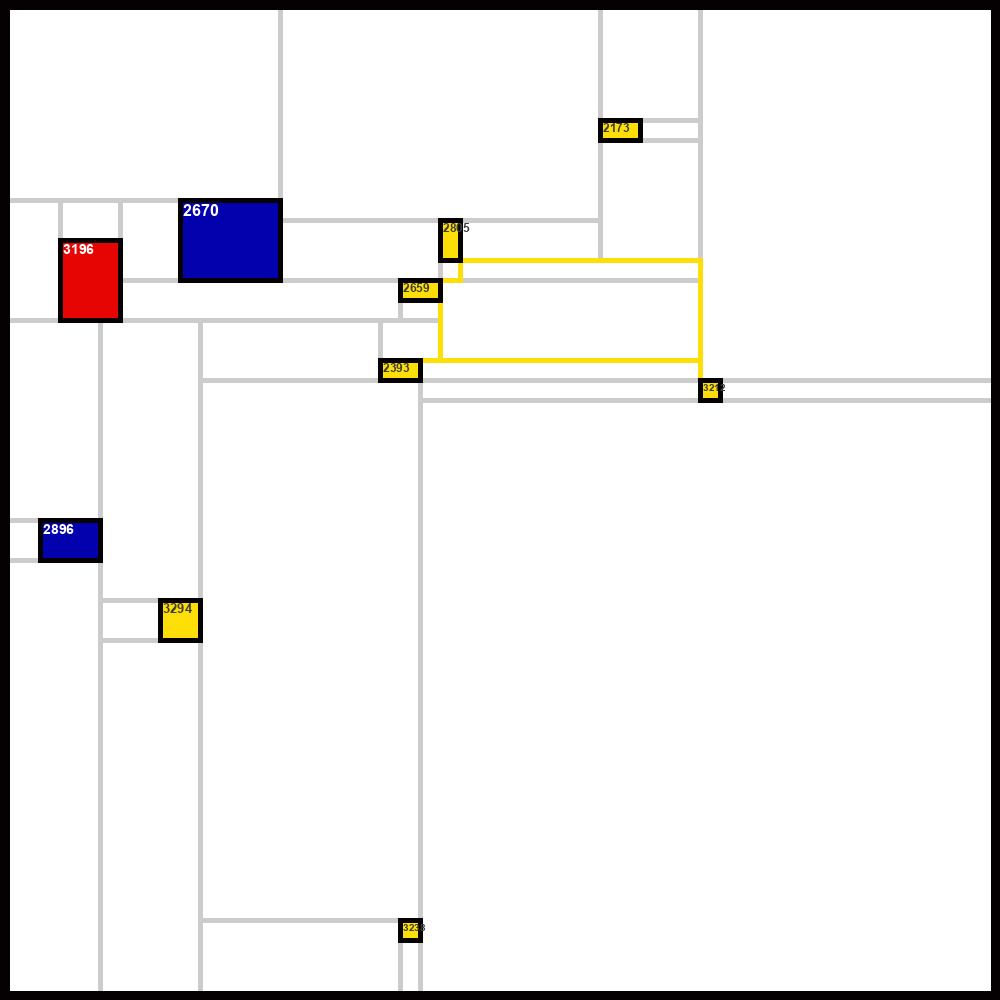

('3212', '2805') False False False
('2659', '2805') False False False
('2393', '2659') False False False
('3212', '2393') False False True


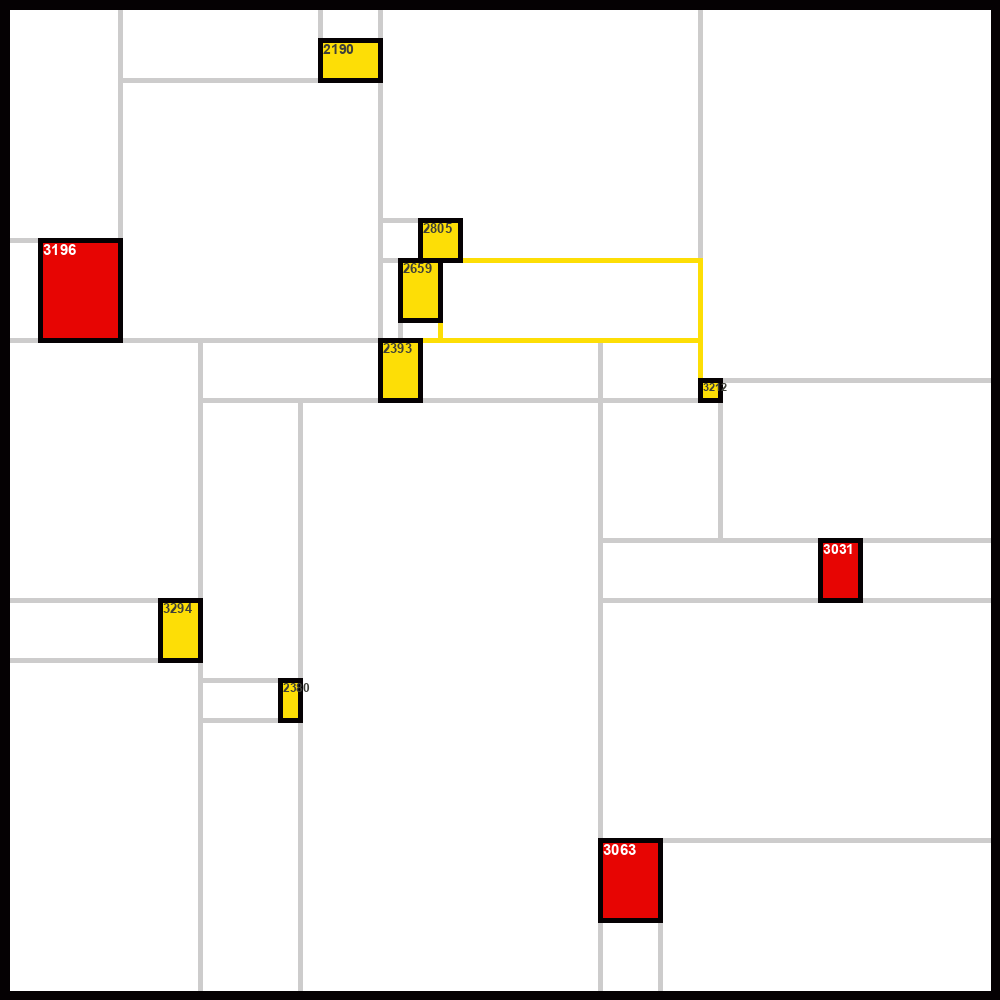

('2483', '2783') False False False
('2133', '2134') False False False
('2483', '2876') False False False
('2876', '2783') False False True


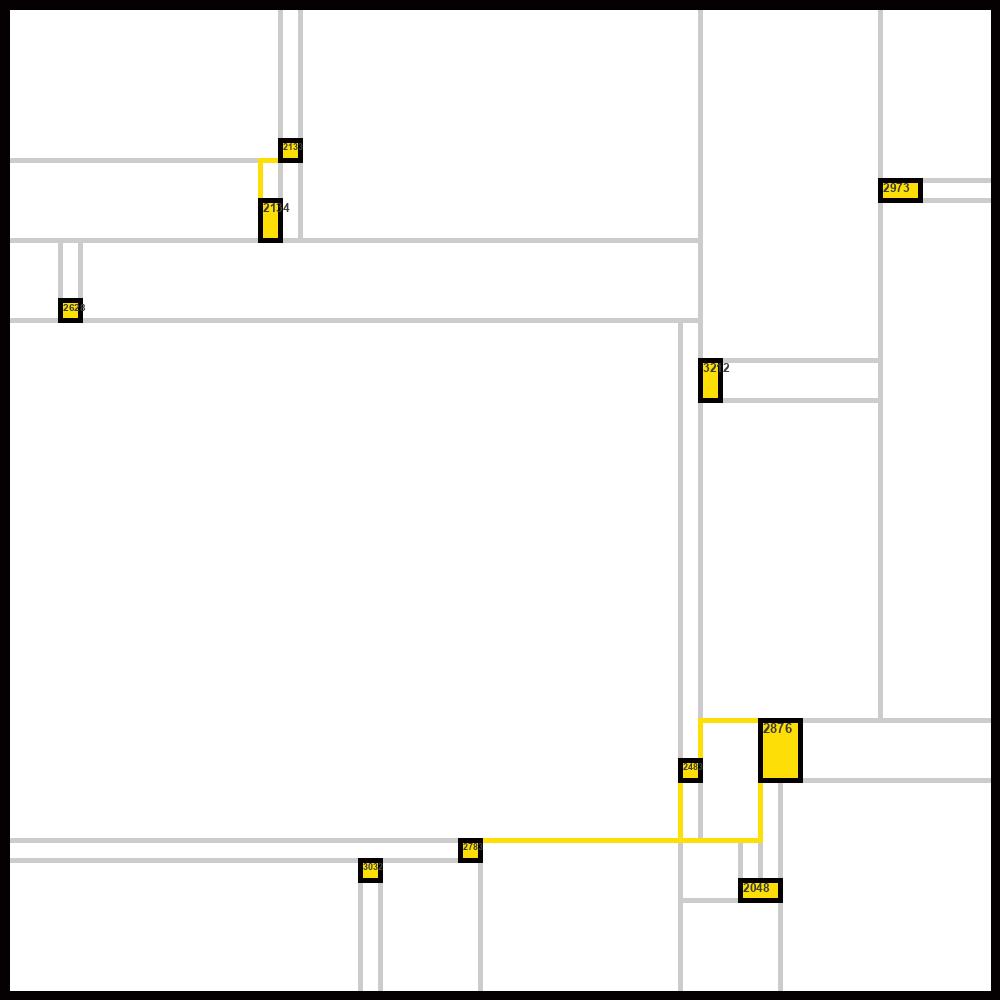

('2783', '2068') False False False
('2483', '2876') False False False
('3212', '3247') False False False
('2783', '2483') False False True
('2133', '2134') False False False


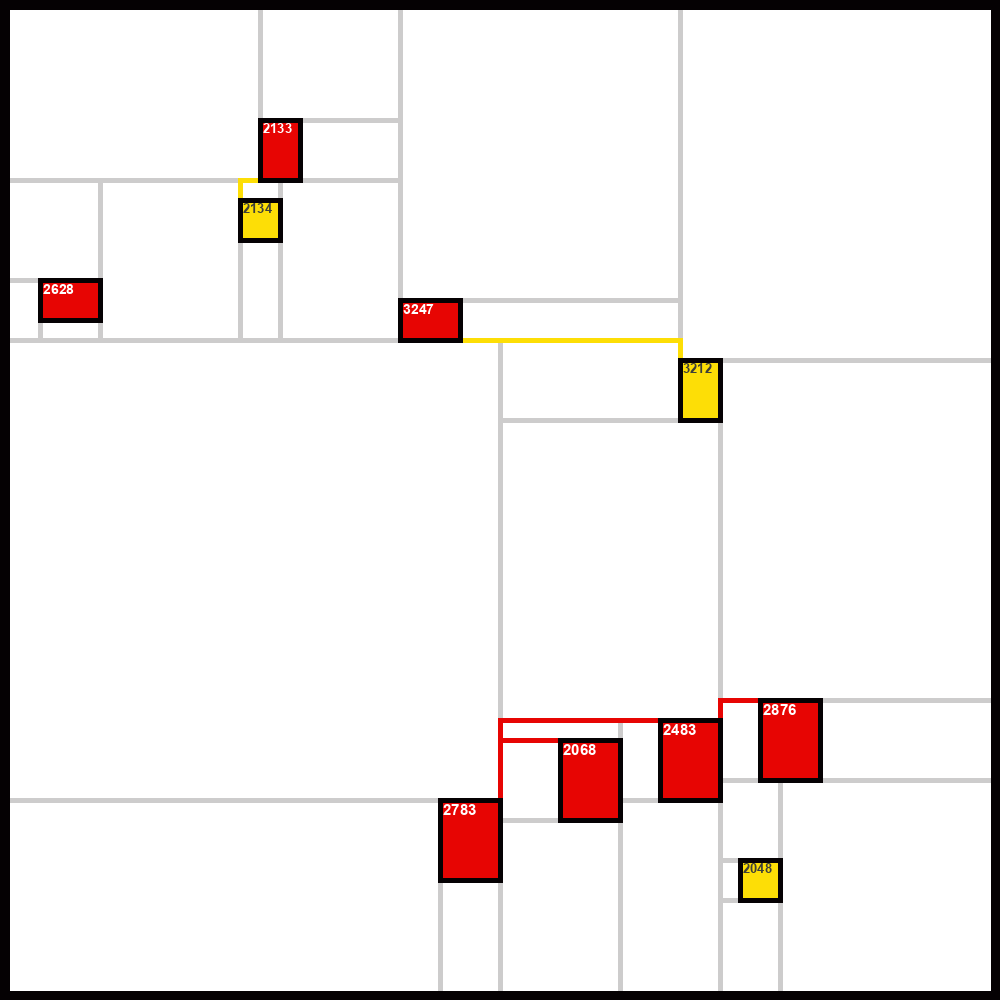

In [ ]:
AREA_SCALAR = 7000
first_batch = False       #True for G1, G2, G3, G4; False for G3, G4, G5, G6

if first_batch:
    G = nx.compose(G1, G2)
    G = nx.compose(G, G3)
    G = nx.compose(G, G4)
else:
    G = nx.compose(G3, G4)
    G = nx.compose(G, G5)
    G = nx.compose(G, G6)
G = color_nodes(G)


valid_set_count = 0
for epoch in range(1000):
    pos = forced_directed_layout(G)
    # vis_g(G, pos)
    # vis_g4(G1, G2, G3, G4, G5, G6, pos)
    pos_apart_scale = 2
    pos = update_pos(G, pos, pos_apart_scale)
    # vis_g4(G1, G2, G3, G4, G5, G6, pos)
    if first_batch:
        reserved_pos = pos
        pag_bR1_s = get_xy(pag_bR1_s, G1, pos)
        pag_bR2_s = get_xy(pag_bR2_s, G2, pos)
        pag_aR1_s = get_xy(pag_aR1_s, G3, pos)
        pag_aR2_s = get_xy(pag_aR2_s, G4, pos)
        pag_mem_dfs = [(pag_bR1_s, m_bR1), (pag_bR2_s, m_bR2), (pag_aR1_s, m_aR1), (pag_aR2_s, m_aR2)]
    else:       # populate reserved pos from first batch
        fixed_positions = {node: reserved_pos[node] for node in reserved_nodes}
        for node in fixed_positions.keys():
            pos[node] = fixed_positions[node]
        pag_aR1_s = get_xy(pag_aR1_s, G3, pos)
        pag_aR2_s = get_xy(pag_aR2_s, G4, pos)
        pag_nR1_s = get_xy(pag_nR1_s, G5, pos)
        pag_nR2_s = get_xy(pag_nR2_s, G6, pos)
        pag_mem_dfs = [(pag_aR1_s, m_aR1), (pag_aR2_s, m_aR2), (pag_nR1_s, m_nR1), (pag_nR2_s, m_nR2)]

    scores = []
    for (pag_df, mem_df) in pag_mem_dfs:
        blank_canvas()
        center_points = get_points(pag_df, 1)
        target_areas = get_area(pag_df, AREA_SCALAR)                   # HYPERPARAMETER
        pag_colors = get_color(pag_df)
        pag_IDs = get_pagIDs(pag_df)
        relations = get_relations(mem_df)

        grid_system = GridSystem(1001, 1001, 20, 20)            # HYPERPARAMETER
        overlap_tolerance = grid_system.block_height * grid_system.block_width * 0

        # for idx, area in enumerate(target_areas):
        #     print(center_points[idx], pag_colors[idx], pag_IDs[idx], area / (grid_system.block_width * grid_system.block_height))
        # print()

        sorted_data = sorted(zip(target_areas, center_points, pag_colors, pag_IDs), reverse=True)
        target_areas_sorted, center_points_sorted, pag_colors, pag_IDs = zip(*sorted_data)
        rectangles, grid_with_filled_blocks_image, score = grid_system.plot_points_fill_blocks(center_points_sorted, target_areas_sorted, visualize=True)

        # rectangles, grid_with_filled_blocks_image, score = grid_system.plot_points_fill_blocks(center_points, target_areas, visualize=True)

        scores.append(score)





    # print(epoch, sum(scores))
    if sum(scores) <= overlap_tolerance:
        valid_set_count += 1


        guardrails = []
        for (pag_df, mem_df) in pag_mem_dfs:
            blank_canvas()
            center_points = get_points(pag_df, 1)
            relations = get_relations(mem_df)
            target_areas = get_area(pag_df, AREA_SCALAR)                   # HYPERPARAMETER
            pag_colors = get_color(pag_df)
            pag_IDs = get_pagIDs(pag_df)

            grid_system = GridSystem(1001, 1001, 20, 20)            # HYPERPARAMETER

            # for idx, area in enumerate(target_areas):
            #     print(center_points[idx], pag_colors[idx], pag_IDs[idx], area / (grid_system.block_width * grid_system.block_height))

            sorted_data = sorted(zip(target_areas, center_points, pag_colors, pag_IDs), reverse=True)
            target_areas_sorted, center_points_sorted, pag_colors, pag_IDs = zip(*sorted_data)
            rectangles, grid_with_filled_blocks_image, score = grid_system.plot_points_fill_blocks(center_points_sorted, target_areas_sorted, visualize=True)

            # rectangles, grid_with_filled_blocks_image, score = grid_system.plot_points_fill_blocks(center_points, target_areas, visualize=True)


            # STAGE 1
            # img = Image.new('RGBA', (1000, 1000), color = 'white')
            # draw = ImageDraw.Draw(img)

            # Line(Point(0, 0), Point(1000, 0), LineDir.RIGHT)
            # Line(Point(1000, 0), Point(1000, 1000), LineDir.DOWN)
            # Line(Point(1000, 1000), Point(0, 1000), LineDir.LEFT)
            # Line(Point(0, 1000), Point(0, 0), LineDir.UP)

            all_blocks = []
            # without draw.Line, 4 per block, with draw.line +16
            for idx, rect in enumerate(rectangles):
                b = Block(rect[0], rect[1], target_areas_sorted[idx], pag_colors[idx], pag_IDs[idx])
                all_blocks.append(b)


            all_manhattan_lines = []
            lines_to_extend = []
            line_intersect_count = 0
            for rel in relations:
                # cp1 = get_closest_corner(Block.instances[rel[0]], Block.instances[rel[1]])
                # cp2 = get_closest_corner(Block.instances[rel[1]], Block.instances[rel[0]])
                # lines = get_manhattan_lines(cp1, cp2)       # alternative: cp2, cp1
                # ====================

                # after
                if rel[0] in Block.instances.keys() and rel[1] in Block.instances.keys():
                    s = Block.instances[rel[0]]
                    b = Block.instances[rel[1]]
                else:
                    continue
                manhattan_line_color = get_manhattan_line_color(s, b)

                cp1 = get_closest_corner(s, b)
                cp2 = None
                dist = float('inf')

                for corner in [b.top_left, b.top_right, b.bottom_left, b.bottom_right]:
                    if (s.top_left.point.x > corner.point.x or s.top_right.point.x < corner.point.x) and (s.top_left.point.y > corner.point.y or s.bottom_left.point.y < corner.point.y):
                        d = euclidean_distance_point((s.center.x, s.center.y), (corner.point.x, corner.point.y))
                        if d < dist:
                            cp2 = corner
                            dist = d
                if cp2 == None:
                    cp2 = get_closest_corner(b, s)
                    con = get_furthest_connector(cp1, cp2, s.center)
                else:
                    con = get_furthest_connector(cp1, cp2, b.center)

                lines = get_manhattan_lines_2(cp1, cp2, con, manhattan_line_color)
                # ========================

                line_intersect = check_manhattan_line_intersection_other_lines(lines, all_manhattan_lines)
                if line_intersect:
                    line_intersect_count += 1

                if len(lines) == 1:
                    all_manhattan_lines.append(lines[0])

                if len(lines) == 2:
                    if get_line_lengths([lines[0]])[0] > LINE_WIDTH:
                        all_manhattan_lines.append(lines[0])
                        lines_to_extend.append(lines[0])
                    if get_line_lengths([lines[1]])[0] > LINE_WIDTH:
                        all_manhattan_lines.append(lines[1])

                atomic_line = is_atomic_line(lines, grid_system)
                block_intersect = check_manhattan_line_intersection(lines, rel)
                # print(rel, atomic_line, block_intersect, line_intersect)

                # guardrails - relax or hard the rules
                guardrails.append(atomic_line or block_intersect or line_intersect_count >= 2)



        print(f"overlap: {score}, guardrails: {sum(guardrails)}")
        if sum(guardrails) == 0:
            for (pag_df, mem_df) in pag_mem_dfs:
                blank_canvas()
                center_points = get_points(pag_df, 1)
                relations = get_relations(mem_df)
                target_areas = get_area(pag_df, AREA_SCALAR)                   # HYPERPARAMETER
                pag_colors = get_color(pag_df)
                pag_IDs = get_pagIDs(pag_df)

                grid_system = GridSystem(1001, 1001, 20, 20)            # HYPERPARAMETER

                # for idx, area in enumerate(target_areas):
                #     print(center_points[idx], pag_colors[idx], pag_IDs[idx], area / (grid_system.block_width * grid_system.block_height))

                sorted_data = sorted(zip(target_areas, center_points, pag_colors, pag_IDs), reverse=True)
                target_areas_sorted, center_points_sorted, pag_colors, pag_IDs = zip(*sorted_data)
                rectangles, grid_with_filled_blocks_image, score = grid_system.plot_points_fill_blocks(center_points_sorted, target_areas_sorted, visualize=True)

                # rectangles, grid_with_filled_blocks_image, score = grid_system.plot_points_fill_blocks(center_points, target_areas, visualize=True)

                # STAGE 1
                img = Image.new('RGBA', (1000, 1000), color = 'white')
                draw = ImageDraw.Draw(img)

                Line(Point(0, 0), Point(1000, 0), LineDir.RIGHT)
                Line(Point(1000, 0), Point(1000, 1000), LineDir.DOWN)
                Line(Point(1000, 1000), Point(0, 1000), LineDir.LEFT)
                Line(Point(0, 1000), Point(0, 0), LineDir.UP)

                all_blocks = []
                # without draw.Line, 4 per block, with draw.line +16
                for idx, rect in enumerate(rectangles):
                    b = Block(rect[0], rect[1], target_areas_sorted[idx], pag_colors[idx], pag_IDs[idx])
                    # b.draw(img)
                    all_blocks.append(b)


                all_manhattan_lines = []
                lines_to_extend = []
                for rel in relations:
                    # cp1 = get_closest_corner(Block.instances[rel[0]], Block.instances[rel[1]])
                    # cp2 = get_closest_corner(Block.instances[rel[1]], Block.instances[rel[0]])
                    # lines = get_manhattan_lines(cp1, cp2)       # alternative: cp2, cp1
                    # ====================

                    # after
                    if rel[0] in Block.instances.keys() and rel[1] in Block.instances.keys():
                        s = Block.instances[rel[0]]
                        b = Block.instances[rel[1]]
                    else:
                        continue
                    manhattan_line_color = get_manhattan_line_color(s, b)

                    cp1 = get_closest_corner(s, b)
                    cp2 = None
                    dist = float('inf')

                    for corner in [b.top_left, b.top_right, b.bottom_left, b.bottom_right]:
                        if (s.top_left.point.x > corner.point.x or s.top_right.point.x < corner.point.x) and (s.top_left.point.y > corner.point.y or s.bottom_left.point.y < corner.point.y):
                            d = euclidean_distance_point((s.center.x, s.center.y), (corner.point.x, corner.point.y))
                            if d < dist:
                                cp2 = corner
                                dist = d
                    if cp2 == None:
                        cp2 = get_closest_corner(b, s)
                        con = get_furthest_connector(cp1, cp2, s.center)
                    else:
                        con = get_furthest_connector(cp1, cp2, b.center)

                    lines = get_manhattan_lines_2(cp1, cp2, con, manhattan_line_color)
                    # ========================


                    line_intersect = check_manhattan_line_intersection_other_lines(lines, all_manhattan_lines)

                    if len(lines) == 1:
                        all_manhattan_lines.append(lines[0])

                    if len(lines) == 2:
                        if get_line_lengths([lines[0]])[0] > LINE_WIDTH:
                            all_manhattan_lines.append(lines[0])
                            lines_to_extend.append(lines[0])
                        if get_line_lengths([lines[1]])[0] > LINE_WIDTH:
                            all_manhattan_lines.append(lines[1])

                    atomic_line = is_atomic_line(lines, grid_system)
                    block_intersect = check_manhattan_line_intersection(lines, rel)
                    print(rel, atomic_line, block_intersect, line_intersect)






                # STAGE 2
                extended_lines = []
                for extend_line in lines_to_extend:
                    vertical_lines = [line for line in Line.instances if line.direction in [LineDir.UP, LineDir.DOWN] and extend_line != line]
                    horizontal_lines = [line for line in Line.instances if line.direction in [LineDir.LEFT, LineDir.RIGHT] and extend_line != line]
                    l = None
                    if extend_line.direction == LineDir.DOWN:
                        h = get_nearest_horizontal_line_below(extend_line.point_b, horizontal_lines)
                        start_point = Point(extend_line.point_b.x, extend_line.point_b.y)
                        end_point = Point(extend_line.point_b.x, h.point_b.y - adjust_e)
                        l = Line(start_point, end_point, get_line_direction(start_point, end_point), color=Colors.BLACK_A, strength=LINE_WIDTH)

                    elif extend_line.direction == LineDir.UP:
                        h = get_nearest_horizontal_line_above(extend_line.point_b, horizontal_lines)
                        start_point = Point(extend_line.point_b.x, extend_line.point_b.y)
                        end_point = Point(extend_line.point_b.x, h.point_b.y + adjust_e)
                        l = Line(start_point, end_point, get_line_direction(start_point, end_point), color=Colors.BLACK_A, strength=LINE_WIDTH)

                    elif extend_line.direction == LineDir.LEFT:
                        h = get_nearest_vertical_line_left(extend_line.point_b, vertical_lines)
                        start_point = Point(extend_line.point_b.x, extend_line.point_b.y)
                        end_point = Point(h.point_b.x + adjust_e, extend_line.point_b.y)
                        l = Line(start_point, end_point, get_line_direction(start_point, end_point), color=Colors.BLACK_A, strength=LINE_WIDTH)

                    elif extend_line.direction == LineDir.RIGHT:
                        h = get_nearest_vertical_line_right(extend_line.point_b, vertical_lines)
                        start_point = Point(extend_line.point_b.x, extend_line.point_b.y)
                        end_point = Point(h.point_b.x - adjust_e, extend_line.point_b.y)
                        l = Line(start_point, end_point, get_line_direction(start_point, end_point), color=Colors.BLACK_A, strength=LINE_WIDTH)

                    if l:
                        extended_lines.append(l)







                # STAGE 3
                corner_lines = []
                for corner in Corner.instances:
                    if corner.line == None:
                        vertical_lines = [line for line in Line.instances if line.direction in [LineDir.UP, LineDir.DOWN]]
                        horizontal_lines = [line for line in Line.instances if line.direction in [LineDir.LEFT, LineDir.RIGHT]]

                        if corner.position == CornerPos.TOP_LEFT:
                            v_line = get_nearest_vertical_line_left(corner.point, vertical_lines)
                            h_line = get_nearest_horizontal_line_above(corner.point, horizontal_lines)
                            v_dist = corner.point.x - v_line.point_a.x
                            h_dist = corner.point.y - h_line.point_a.y
                            # DECISION POINT
                            if v_dist < h_dist:
                                corner_point = Point(corner.point.x, corner.point.y + adjust)
                                point_on_line = Point(v_line.point_a.x, corner.point.y + adjust)
                            else:
                                corner_point = Point(corner.point.x + adjust, corner.point.y)
                                point_on_line = Point(corner.point.x + adjust, h_line.point_a.y)

                        elif corner.position == CornerPos.TOP_RIGHT:
                            v_line = get_nearest_vertical_line_right(corner.point, vertical_lines)
                            h_line = get_nearest_horizontal_line_above(corner.point, horizontal_lines)
                            v_dist = v_line.point_a.x - corner.point.x
                            h_dist = corner.point.y - h_line.point_a.y
                            if v_dist < h_dist:
                                corner_point = Point(corner.point.x, corner.point.y + adjust)
                                point_on_line = Point(v_line.point_a.x, corner.point.y + adjust)
                            else:
                                corner_point = Point(corner.point.x - adjust, corner.point.y)
                                point_on_line = Point(corner.point.x - adjust, h_line.point_a.y)

                        elif corner.position == CornerPos.BOTTOM_RIGHT:
                            v_line = get_nearest_vertical_line_right(corner.point, vertical_lines)
                            h_line = get_nearest_horizontal_line_below(corner.point, horizontal_lines)
                            v_dist = v_line.point_a.x - corner.point.x
                            h_dist = h_line.point_a.y - corner.point.y
                            if v_dist < h_dist:
                                corner_point = Point(corner.point.x, corner.point.y - adjust)
                                point_on_line = Point(v_line.point_a.x, corner.point.y - adjust)
                            else:
                                corner_point = Point(corner.point.x - adjust, corner.point.y)
                                point_on_line = Point(corner.point.x - adjust, h_line.point_a.y)

                        elif corner.position == CornerPos.BOTTOM_LEFT:
                            v_line = get_nearest_vertical_line_left(corner.point, vertical_lines)
                            h_line = get_nearest_horizontal_line_below(corner.point, horizontal_lines)
                            v_dist = corner.point.x - v_line.point_a.x
                            h_dist = h_line.point_a.y - corner.point.y
                            if v_dist < h_dist:
                                corner_point = Point(corner.point.x, corner.point.y - adjust)
                                point_on_line = Point(v_line.point_a.x, corner.point.y - adjust)
                            else:
                                corner_point = Point(corner.point.x + adjust, corner.point.y)
                                point_on_line = Point(corner.point.x + adjust, h_line.point_a.y)

                        l = Line(corner_point, point_on_line, get_line_direction(corner_point, point_on_line), color=Colors.BLACK_A, strength=LINE_WIDTH)
                        corner_lines.append(l)

                for line in corner_lines:
                    line.draw(img)

                for line in extended_lines:
                    line.draw(img)

                for line in all_manhattan_lines:
                    line.draw(img)

                for b in all_blocks:
                    b.draw(img)

                draw.rectangle((0, 0, 1000, 1000), outline=Colors.BLACK, width=10)
                display(img)
            break

In [ ]:
pag_bR1_s.to_csv(f"pag_bR1_s{count}.csv")
pag_bR2_s.to_csv(f"pag_bR2_s{count}.csv")
pag_aR1_s.to_csv(f"pag_aR1_s{count}.csv")
pag_aR2_s.to_csv(f"pag_aR2_s{count}.csv")
pag_nR1_s.to_csv(f"pag_nR1_s{count}.csv")
pag_nR2_s.to_csv(f"pag_nR2_s{count}.csv")